In [1]:
!pip install econml --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 40.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.4/259.4 kB 14.6 MB/s eta 0:00:00


In [2]:
!pip install dowhy --quiet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 403.1/403.1 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.0/193.0 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 31.6 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
from dowhy import CausalModel
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from econml.dml import CausalForestDML
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from econml.dml import CausalForestDML
import yfinance as yf
from google.colab import files

# BASE DE DATOS

In [4]:
df = pd.read_csv('methanol.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2772 entries, 0 to 2771
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Date              2771 non-null   object
 1   CMAc1 (TRDPRC_1)  2772 non-null   object
dtypes: object(2)
memory usage: 43.4+ KB


In [7]:
dff=df.copy()
dff['Date'] = pd.to_datetime(dff['Date'], dayfirst=True)

In [ ]:
dff

,Date,Price
0,2021-10-03,341.00
1,2021-11-03,341.00
2,2021-12-03,341.00
3,2021-03-15,335.00
4,2021-03-16,335.00
...,...,...
1051,2025-11-21,237.00
1052,2025-11-24,242.50
1053,2025-11-25,242.50
1054,2025-11-26,245.00


In [8]:
tickers = [
    "CF","300505.SZ","600141.SS","BWET","NBP=F","NG=F","YARIY",
    "MXN=X","^MXX","^IRX","CL=F","HO=F","QH=F","^GSPC","^TNX",
    "DX-Y.NYB","GC=F","^VIX","EUR=X","^STOXX50E","BZ=F","^XOI",
    "DBC","RB=F","MTF=F","XLE",
    "MEOH","DOW","LYB","BASFY",
    "GSG","IYT","FDX",
    "USDCNY=X","USDEUR=X",
    "^SOX","XLI"
]
start = "2021-03-10"
end = "2025-11-28"

# Descargar datos mensuales y quedarte solo con Close
df_y = yf.download(tickers, start=start, end=end)["Close"]

/tmp/ipython-input-1808489053.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_y = yf.download(tickers, start=start, end=end)["Close"]
[*********************100%***********************]  37 of 37 completed


In [9]:
df_merged = pd.merge(df_y, dff, on='Date', how='inner')

In [10]:
df_merged.isnull().sum()

,0
Date,0
300505.SZ,0
600141.SS,0
BASFY,41
BWET,544
BZ=F,38
CF,41
CL=F,39
DBC,41
DOW,41


In [11]:
from sklearn.impute import KNNImputer
import pandas as pd
import numpy as np

# Select only numerical columns for imputation
numeric_columns = df_merged.select_dtypes(include=np.number).columns
df_numeric_only = df_merged[numeric_columns]

# IMPUTAR KNN
imputer = KNNImputer(n_neighbors=5)
df_imputed_values = imputer.fit_transform(df_numeric_only)

# Create a new DataFrame with imputed values and original column names/index
df_merged_imputed = pd.DataFrame(df_imputed_values,
                                 columns=numeric_columns,
                                 index=df_merged.index)

# Update df_merged with the imputed numerical values, preserving the 'Date' column
df_merged_copy = df_merged.copy()
for col in numeric_columns:
    df_merged_copy[col] = df_merged_imputed[col]

df_merged = df_merged_copy

In [16]:
# Rename the original price column to 'Price' if it exists, otherwise do nothing (or handle if it has been renamed already)
if 'CMAc1 (TRDPRC_1)' in df_merged.columns:
    df_merged = df_merged.rename(columns={'CMAc1 (TRDPRC_1)': 'Price'})

# Convert the 'Price' column to numeric, coercing errors to NaN
df_merged['Price'] = pd.to_numeric(df_merged['Price'], errors='coerce')

# Ensure 'Date' is the index if not already and apply log transformation
if 'Date' in df_merged.columns:
    df_merged = df_merged.set_index('Date')

df_merged = np.log(df_merged / df_merged.shift(1))

df_merged.dropna(inplace=True)

In [ ]:
#data frame creation:
np.random.seed(42)

# Simulamos un dataset de ejemplo
n = 2000

# Covariables (X: características que afectan outcome y tratamiento)
X1 = np.random.normal(0, 1, n)
X2 = np.random.normal(0, 1, n)

# Tratamiento binario (T)
# Probabilidad de tratamiento depende de X1, X2 (confounding)
p_treat = 1 / (1 + np.exp(-(0.5*X1 - 0.3*X2)))
T = np.random.binomial(1, p_treat)

# Outcome (Y) con efecto causal verdadero de +2 para los tratados
# y algo de ruido
tau_true = 2.0
Y = 1 + 0.8*X1 - 0.5*X2 + tau_true*T + np.random.normal(0, 1, n)

# Construimos DataFrame
df = pd.DataFrame({
    "Y": Y,
    "T": T,
    "X1": X1,
    "X2": X2
})

df.head()

,Y,T,X1,X2
0,3.066817,1,0.496714,-0.675178
1,1.155027,0,-0.138264,-0.144519
2,0.566184,0,0.647689,-0.792420
3,4.388087,1,1.523030,-0.307962
4,3.659753,0,-0.234153,-1.893615


In [17]:
df_merged.columns

Index(['300505.SZ', '600141.SS', 'BASFY', 'BWET', 'BZ=F', 'CF', 'CL=F', 'DBC',
       'DOW', 'DX-Y.NYB', 'EUR=X', 'FDX', 'GC=F', 'GSG', 'HO=F', 'IYT', 'LYB',
       'MEOH', 'MTF=F', 'MXN=X', 'NBP=F', 'NG=F', 'QH=F', 'RB=F', 'USDCNY=X',
       'USDEUR=X', 'XLE', 'XLI', 'YARIY', '^GSPC', '^IRX', '^MXX', '^SOX',
       '^STOXX50E', '^TNX', '^VIX', '^XOI', 'Price'],
      dtype='object')

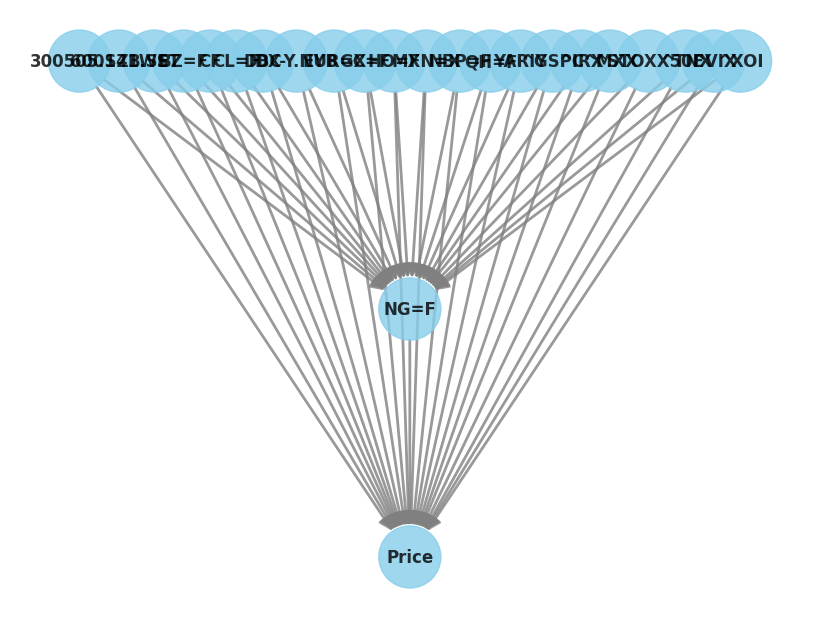

In [18]:
model = CausalModel(
    data=df_merged,
    treatment='NG=F',
    outcome='Price',
    common_causes=['300505.SZ', '600141.SS', 'BWET', 'BZ=F', 'CF', 'CL=F', 'DBC',
       'DX-Y.NYB', 'EUR=X', 'GC=F', 'HO=F', 'MXN=X', 'NBP=F', 'QH=F',
       'YARIY', '^GSPC', '^IRX', '^MXX', '^STOXX50E', '^TNX', '^VIX', '^XOI'
    ]
)

model.view_model(layout="dot")

2.2 Identificar y estimar el efecto causal

In [19]:
# IDENTIFICAR la expresión del efecto
identified_estimand = model.identify_effect()
print("Estimand identificado:\n", identified_estimand)

estimate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.econml.dml.LinearDML",
    method_params={
        "init_params": {
            "discrete_treatment": False  # True si T es binaria
        }
    }
)
print("ATE (DoWhy + LinearDML):", estimate.value)

/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Estimand identificado:
 Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                                                                           ↪
───────(E[Price|__IRX,__GSPC,__STOXX50E,QH=F,__VIX,CL=F,HO=F,300505.SZ,MXN=X,C ↪
d[NG=F]                                                                        ↪

↪                                                                              ↪
↪ F,EUR=X,__XOI,__TNX,BZ=F,NBP=F,600141.SS,GC=F,BWET,DBC,DX-Y.NYB,YARIY,__MXX] ↪
↪                                                                              ↪

↪  
↪ )
↪  
Estimand assumption 1, Unconfoundedness: If U→{NG=F} and U→Price then P(Price|NG=F,^IRX,^GSPC,^STOXX50E,QH=F,^VIX,CL=F,HO=F,300505.SZ,MXN=X,CF,EUR=X,^XOI,^TNX,BZ=F,NBP=F,600141.SS,GC=F,BWET,DBC,DX-Y.NYB,YARIY,^MXX,U) = P(Price|NG=F,^IRX,^GSPC,^STOXX50E,QH=F,^VIX,CL=F,HO=F,300505.SZ,MXN=X,CF,EUR=X,^XOI,^TNX,BZ=F,NBP=F,600141.SS,GC=F,BWET,DBC,DX-Y.NYB,YARIY,^MXX)

##

/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


ATE (DoWhy + LinearDML): 0.011223193906140905


2.3 Refutaciones (robustez)

# EconML: CausalForestDML

In [20]:
df_merged.columns

Index(['300505.SZ', '600141.SS', 'BASFY', 'BWET', 'BZ=F', 'CF', 'CL=F', 'DBC',
       'DOW', 'DX-Y.NYB', 'EUR=X', 'FDX', 'GC=F', 'GSG', 'HO=F', 'IYT', 'LYB',
       'MEOH', 'MTF=F', 'MXN=X', 'NBP=F', 'NG=F', 'QH=F', 'RB=F', 'USDCNY=X',
       'USDEUR=X', 'XLE', 'XLI', 'YARIY', '^GSPC', '^IRX', '^MXX', '^SOX',
       '^STOXX50E', '^TNX', '^VIX', '^XOI', 'Price'],
      dtype='object')

In [21]:
# 1) Y original en log-retornos
Y_log = df_merged['Price']   # ya está en rendimientos log

# 2) Y suavizado (ej. media de 5 días hacia adelante)
Y_smooth = Y_log.rolling(10).mean().shift(-9)

# 3) Definimos T y X normalmente (MISMO df_merged)
T = df_merged['NG=F'].values

X = df_merged[['300505.SZ', '600141.SS', 'BWET', 'BZ=F', 'CF', 'CL=F', 'DBC',
       'DX-Y.NYB', 'EUR=X', 'GC=F', 'HO=F', 'MXN=X', 'NBP=F', 'QH=F',
       'YARIY', '^GSPC', '^IRX', '^MXX', '^STOXX50E', '^TNX', '^VIX', '^XOI']].values

# 4) Máscara: solo filas donde Y_smooth NO es NaN
mask = ~Y_smooth.isna()

Y = Y_smooth[mask].values
X = X[mask.values, :]
T = T[mask.values]

W = None

# 5) Ahora sí, todos tienen la MISMA longitud
print(len(X), len(T), len(Y))  # debería darte algo como 2028,2028,2028

X_train, X_test, T_train, T_test, Y_train, Y_test = train_test_split(
    X, T, Y, test_size=0.2, random_state=42
)

1121 1121 1121


HIPERPARAMETRIZACIÓN

In [23]:
# --- Grid de hiperparámetros ---
param_grid = {
    "n_estimators": [300, 600, 1200], #[300, 600, 1200],
    "max_depth": [None, 10, 20, 30],
    "min_samples_leaf": [1, 3, 5, 10],
    "max_features": ["auto", "sqrt", "log2"]
}
def tune_rf(X, y):
    """Entrena GridSearchCV para un RandomForestRegressor y devuelve el mejor modelo."""
    grid = GridSearchCV(
        RandomForestRegressor(), # Corrected: Pass an instance of the estimator
        param_grid,
        cv=3,
        scoring="neg_mean_squared_error",
        n_jobs=-1
    )
    grid.fit(X, y)
    print("Mejores hiperparámetros:", grid.best_params_)
    return grid.best_estimator_

# --- Hiperparametrizar modelos ---
model_y_best = tune_rf(X_train, Y_train)
model_t_best = tune_rf(X_train, T_train)

/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
144 fits failed out of a total of 432.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
144 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.12/dist-packages/sklearn/util

Mejores hiperparámetros: {'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 10, 'n_estimators': 300}


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
144 fits failed out of a total of 432.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
144 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py",

Mejores hiperparámetros: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'n_estimators': 300}


In [24]:
cf = CausalForestDML(
    model_y=model_y_best,
    model_t=model_t_best,
    n_estimators=2000,
    min_samples_leaf=5,
    max_depth=30,
    min_impurity_decrease=0.0,
    verbose=0,
    random_state=42
)
# Ajustar el modelo causal
cf.fit(Y_train, T_train, X=X_train, W=None)

In [25]:
# Verificación del modelo
ate = cf.ate(X_train)
lb, ub = cf.ate_interval(X_train)

print("ATE:", ate)
print("95% CI:", lb, ub)

ATE: 0.0015166087516336854
95% CI: -0.007701754401236988 0.010734971904504356


3.3 Estimar CATE para cada observación

In [26]:
# Obtener efectos heterogéneos (CATE)
cate = cf.effect(X_train)

# Resumen estadístico
import numpy as np
print("PROMEDIO CATE:", np.mean(cate))
print("MEDIANA CATE:", np.median(cate))
print("DESVIACIÓN:", np.std(cate))
print("MÍNIMO:", np.min(cate))
print("MÁXIMO:", np.max(cate))

PROMEDIO CATE: 0.0015166087516336854
MEDIANA CATE: 0.001313279723366176
DESVIACIÓN: 0.0031347628358427155
MÍNIMO: -0.009804499524941218
MÁXIMO: 0.016284148908853813


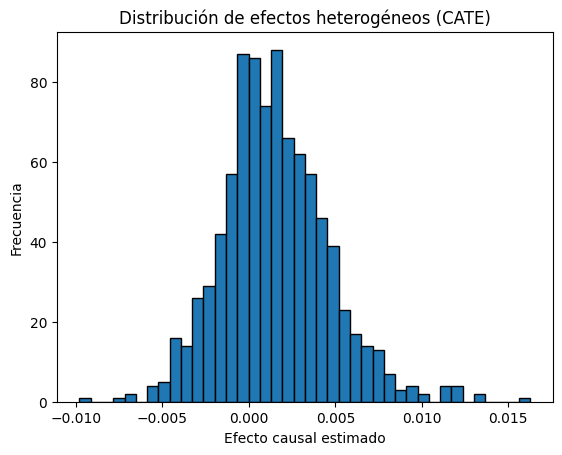

In [27]:
import matplotlib.pyplot as plt

plt.hist(cate, bins=40, edgecolor='black')
plt.title("Distribución de efectos heterogéneos (CATE)")
plt.xlabel("Efecto causal estimado")
plt.ylabel("Frecuencia")
plt.show()

In [28]:
df_merged.columns

Index(['300505.SZ', '600141.SS', 'BASFY', 'BWET', 'BZ=F', 'CF', 'CL=F', 'DBC',
       'DOW', 'DX-Y.NYB', 'EUR=X', 'FDX', 'GC=F', 'GSG', 'HO=F', 'IYT', 'LYB',
       'MEOH', 'MTF=F', 'MXN=X', 'NBP=F', 'NG=F', 'QH=F', 'RB=F', 'USDCNY=X',
       'USDEUR=X', 'XLE', 'XLI', 'YARIY', '^GSPC', '^IRX', '^MXX', '^SOX',
       '^STOXX50E', '^TNX', '^VIX', '^XOI', 'Price'],
      dtype='object')

In [30]:
colnames = ['300505.SZ', '600141.SS', 'BWET', 'BZ=F', 'CF', 'CL=F', 'DBC',
       'DX-Y.NYB', 'EUR=X', 'GC=F', 'HO=F', 'MXN=X', 'NBP=F', 'QH=F',
       'YARIY', '^GSPC', '^IRX', '^MXX', '^STOXX50E', '^TNX', '^VIX', '^XOI']

X_train_df = pd.DataFrame(X_train, columns=colnames)

In [31]:
imp_y = pd.Series(model_y_best.feature_importances_, index=X_train_df.columns)
imp_t = pd.Series(model_t_best.feature_importances_, index=X_train_df.columns)

print("\n====== TOP 15 IMPORTANCIA MODELO Y ======")
print(imp_y.sort_values(ascending=False).head(15))

print("\n====== TOP 15 IMPORTANCIA MODELO T ======")
print(imp_t.sort_values(ascending=False).head(15))


====== TOP 15 IMPORTANCIA MODELO Y ======
600141.SS    0.074499
^IRX         0.069043
NBP=F        0.053561
300505.SZ    0.053112
CF           0.052727
^TNX         0.052178
^XOI         0.048268
^GSPC        0.047511
MXN=X        0.047238
^STOXX50E    0.045054
DBC          0.044234
YARIY        0.043078
^VIX         0.041979
BWET         0.041762
GC=F         0.038373
dtype: float64

====== TOP 15 IMPORTANCIA MODELO T ======
NBP=F       0.118889
DBC         0.107824
^GSPC       0.072760
HO=F        0.064837
YARIY       0.057389
CF          0.051659
GC=F        0.044810
DX-Y.NYB    0.044190
^XOI        0.044179
CL=F        0.041652
^TNX        0.040860
^IRX        0.038905
QH=F        0.038607
BZ=F        0.035935
BWET        0.035729
dtype: float64


In [32]:
imp_y = pd.Series(model_y_best.feature_importances_, index=X_train_df.columns)
imp_t = pd.Series(model_t_best.feature_importances_, index=X_train_df.columns)

print("\n====== TOP 15 IMPORTANCIA MODELO Y ======")
print(imp_y.sort_values(ascending=False).head(15))

print("\n====== TOP 15 IMPORTANCIA MODELO T ======")
print(imp_t.sort_values(ascending=False).head(15))


====== TOP 15 IMPORTANCIA MODELO Y ======
600141.SS    0.074499
^IRX         0.069043
NBP=F        0.053561
300505.SZ    0.053112
CF           0.052727
^TNX         0.052178
^XOI         0.048268
^GSPC        0.047511
MXN=X        0.047238
^STOXX50E    0.045054
DBC          0.044234
YARIY        0.043078
^VIX         0.041979
BWET         0.041762
GC=F         0.038373
dtype: float64

====== TOP 15 IMPORTANCIA MODELO T ======
NBP=F       0.118889
DBC         0.107824
^GSPC       0.072760
HO=F        0.064837
YARIY       0.057389
CF          0.051659
GC=F        0.044810
DX-Y.NYB    0.044190
^XOI        0.044179
CL=F        0.041652
^TNX        0.040860
^IRX        0.038905
QH=F        0.038607
BZ=F        0.035935
BWET        0.035729
dtype: float64


In [36]:
corr = X_train_df.corr().abs()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

colineales = [c for c in upper.columns if any(upper[c] > 0.80)]

print("\n====== VARIABLES CON CORRELACIÓN > 0.80 ======")
print(colineales)


====== VARIABLES CON CORRELACIÓN > 0.80 ======
['CL=F', 'HO=F', '^TNX', '^XOI']


In [37]:
low_var = X_train_df.columns[X_train_df.std() < 1e-5]

print("\n====== VARIANZA CASI CERO ======")
print(list(low_var))


====== VARIANZA CASI CERO ======
[]


In [38]:
stats = X_train_df.describe().T[['std']]
zscale = (stats['std'] - stats['std'].mean()) / stats['std'].std()
escala_extrema = zscale[abs(zscale) > 3].index

print("\n====== VARIABLES CON ESCALA EXTREMA ======")
print(list(escala_extrema))


====== VARIABLES CON ESCALA EXTREMA ======
['^IRX']


In [39]:
Y_col = 'Price'      # o 'Prices' si así se llama
T_col = 'NG=F'

X_cols = [
    '300505.SZ','600141.SS','BWET','BZ=F','CF','CL=F','DBC',
    'DX-Y.NYB','EUR=X','GC=F','HO=F','MXN=X','NBP=F','NG=F','QH=F',
    'YARIY','^GSPC','^IRX','^MXX','^STOXX50E','^TNX','^VIX','^XOI'
]

df_final = df_merged[[Y_col, T_col] + X_cols].dropna().copy()
df_final = df_final.rename(columns={Y_col: 'Y', T_col: 'T'})

In [40]:
from dowhy import CausalModel
from IPython.display import Image, display

from dowhy import CausalModel

model = CausalModel(
    data=df_final,
    treatment="T",
    outcome="Y",
    common_causes=X_cols
)

/usr/local/lib/python3.12/dist-packages/dowhy/causal_model.py:581: UserWarning: 1 variables are assumed unobserved because they are not in the dataset. Configure the logging level to `logging.WARNING` or higher for additional details.
  warnings.warn(


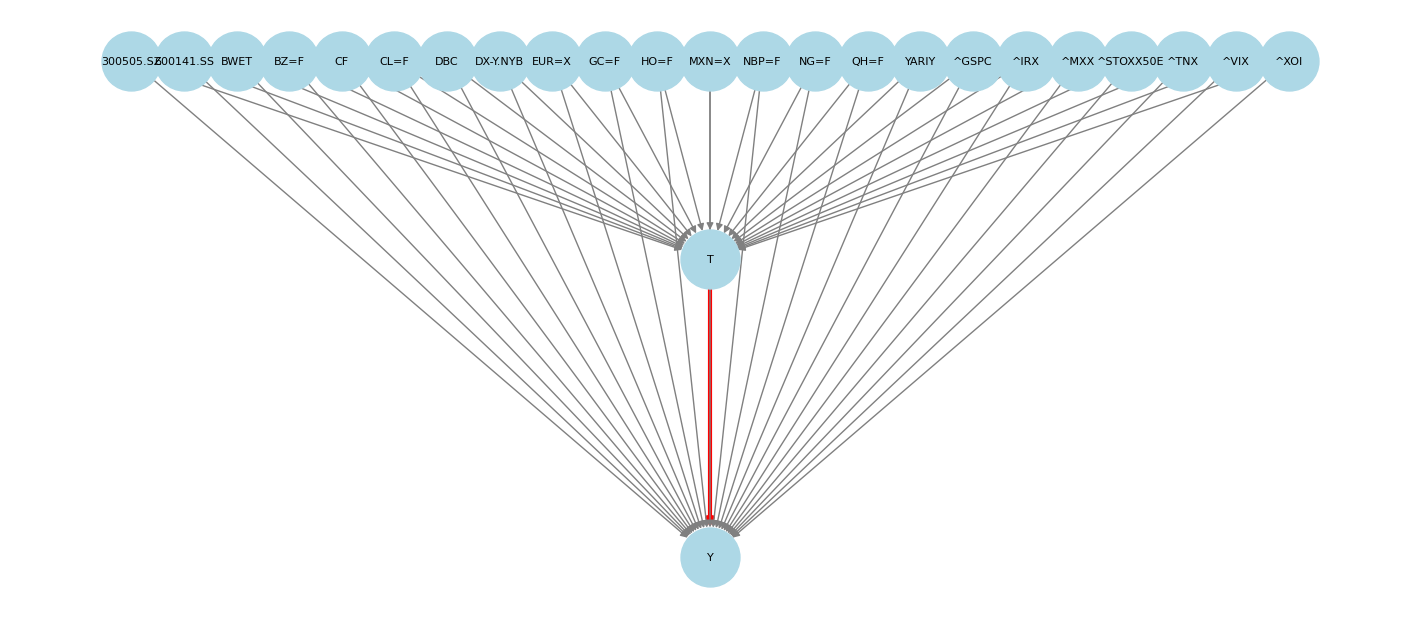

In [41]:
import networkx as nx
import matplotlib.pyplot as plt

G = model._graph._graph   # grafo interno de DoWhy

pos = {}

# 1) X en una línea horizontal arriba (y = 1)
for i, x in enumerate(X_cols):
    pos[x] = (i, 1)     # X separados en el eje horizontal

# 2) T centrado debajo de las X
center_x = (len(X_cols) - 1) / 2   # punto medio de la fila de X
pos['T'] = (center_x, 0)

# 3) Y más abajo, centrado también
pos['Y'] = (center_x, -1.5)

# Colores: rojo para T->Y, gris para el resto
edges = list(G.edges())
edge_colors = ['red' if (u == 'T' and v == 'Y') else 'gray' for u, v in edges]
edge_widths = [3 if (u == 'T' and v == 'Y') else 1 for u, v in edges]

plt.figure(figsize=(14, 6))
nx.draw(
    G,
    pos,
    with_labels=True,
    arrows=True,
    node_color="lightblue",
    node_size=1800,
    font_size=8,
    edge_color=edge_colors,
    width=edge_widths
)

plt.axis("off")
plt.show()

# Cross Headge

In [43]:
uploaded_h = files.upload()
ch = pd.read_csv('methanol.csv')

Saving methanol.csv to methanol (1).csv


In [46]:
ch=ch.rename(columns={'Fecha':'Date'})
ch['Date']=pd.to_datetime(ch['Date'], dayfirst=True)
ch=ch.set_index('Date')

In [47]:
# Descargar datos mensuales y quedarte solo con Close
xh = yf.download("MXN=X", start='2023-01-01', end='2025-10-01',interval="1mo")["Close"]

/tmp/ipython-input-3163229548.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  xh = yf.download("MXN=X", start='2023-01-01', end='2025-10-01',interval="1mo")["Close"]
[*********************100%***********************]  1 of 1 completed


In [49]:
# Handle ch DataFrame:
ch['CMAc1 (TRDPRC_1)'] = pd.to_numeric(ch['CMAc1 (TRDPRC_1)'], errors='coerce')
ch = ch.dropna(subset=['CMAc1 (TRDPRC_1)'])
ch.index = ch.index.to_period('M')
ch = ch.groupby(ch.index).last() # Aggregate to ensure unique monthly index
ch.index = ch.index.to_timestamp()

# Handle xh DataFrame:
xh.index = xh.index.to_period('M').to_timestamp()

df = pd.concat([ch, xh], axis=1, join='inner').select_dtypes(include=['float', 'int'])
rets = np.log(df / df.shift(1)).dropna()

In [50]:
import statsmodels.api as sm

# --- Identificar columnas automáticamente ---
urea_ret = rets.iloc[:, 0]     # retornos de urea
fx_ret   = rets.iloc[:, 1]     # retornos del tipo de cambio

# --- Regresión OLS para obtener Optimal Hedge Ratio ---
X = sm.add_constant(fx_ret)
model = sm.OLS(urea_ret, X).fit()

hedge_ratio = model.params[1]

print("Optimal Hedge Ratio:", hedge_ratio)
print(model.summary())

Optimal Hedge Ratio: 0.4347992335634822
                            OLS Regression Results                            
Dep. Variable:       CMAc1 (TRDPRC_1)   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     1.415
Date:                Sun, 30 Nov 2025   Prob (F-statistic):              0.244
Time:                        19:40:08   Log-Likelihood:                 48.488
No. Observations:                  32   AIC:                            -92.98
Df Residuals:                      30   BIC:                            -90.04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       

/tmp/ipython-input-2817477418.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hedge_ratio = model.params[1]
